# Introduktion

Detta arbete undersöker hur en CNN model tolkar & klassar bilder genom att visualisera aktiveringsmönstret i olika lager. För att testa modellens beslutsprocess använder jag "hybriddjur", digitala collage som kombinerar djurarter. Detta blir särskilt intressant eftersom det förhoppningsvis blir lätt att avgöra om det är små detaljer eller en helhet som avgör mest i predictions, och vilka lager som har störst betydelse.


In [1]:
import torch
import matplotlib.pyplot as plt
from torchcam.methods import LayerCAM
from torchvision.io import decode_image
from torchvision.models import get_model, get_model_weights
from torchinfo import summary
from torchcam.utils import overlay_mask
from torchvision.transforms.v2.functional import to_pil_image

In [2]:
weights = get_model_weights("resnet50").DEFAULT
model = get_model("resnet50", weights=weights).eval()
device = "cuda"
model.to(device)
preprocess = weights.transforms()
class_names = weights.meta["categories"]
print(class_names)
summary(model, input_size=(1, 3, 224, 224))

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'European fire salamander', 'common newt', 'eft', 'spotted salamander', 'axolotl', 'bullfrog', 'tree frog', 'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'common iguana', 'American chameleon', 'whiptail', 'agama', 'frilled lizard', 'alligator lizard', 'Gila monster', 'green lizard', 'African chameleon', 'Komodo dragon', 'African crocodile', 'American alligator', 'triceratops', 'thunder snake', 'ringneck snake', 'hognose snake', 'green snake', 'king snake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor', 'rock python', 'Indian cobra', 'green mamba', 'sea snake', 'horned viper', 'diamondback', 

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

In [3]:
def process_image(image_path):
    
    image = decode_image(image_path)
    image_tensor = preprocess(image)
    image_tensor = image_tensor.to(device)
    return image, image_tensor


def overlay_cam(img, tensor):
    
    layercam = LayerCAM(model, target_layer=["layer1", "layer2", "layer3", "layer4"])
    output = model(tensor.unsqueeze(0))
    class_idx = output.squeeze(0).argmax().item()
    cams = layercam(class_idx, output)
    
    fig = plt.figure(figsize=(12, 10))
    
    ax_orig = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    ax_orig.imshow(to_pil_image(img))
    ax_orig.axis("off")
    ax_orig.set_title(f"Original bild - Predicted: {class_names[class_idx]}")
    
    layer_names = ["Layer 1", "Layer 2", "Layer 3", "Layer 4"]
    positions = [(1, 0), (1, 1), (2, 0), (2, 1)]
    
    for i, (cam, name, pos) in enumerate(zip(cams, layer_names, positions)):
        ax = plt.subplot2grid((3, 2), pos)
        cam = cam.squeeze(0)
        result = overlay_mask(to_pil_image(img), to_pil_image(cam, mode='F'), alpha=0.4)
        ax.imshow(result)
        ax.axis("off")
        ax.set_title(name)
    
    plt.tight_layout()
    plt.show()
    
    probs = torch.nn.functional.softmax(output, dim=1)
    top_prob, top_class_index = torch.topk(probs, 10)
    
    print("predictions:")
    for i, (prob, class_index) in enumerate(zip(top_prob[0], top_class_index[0]), 1):
        print(f"{i}. {class_names[class_index]:<24} {prob:.3f}")

Jag använder LayerCAM, class activation mapping, för att visualisera vilka delar av bilden som har betydelse för klassifieringen modellen gör. Layercam visar vart i bilden modellen "tittar" när den gör predictions. Nedan visualiseras 4 lager i resnet50 för att se skillnaden på vad de olika lagren fokuserar på.

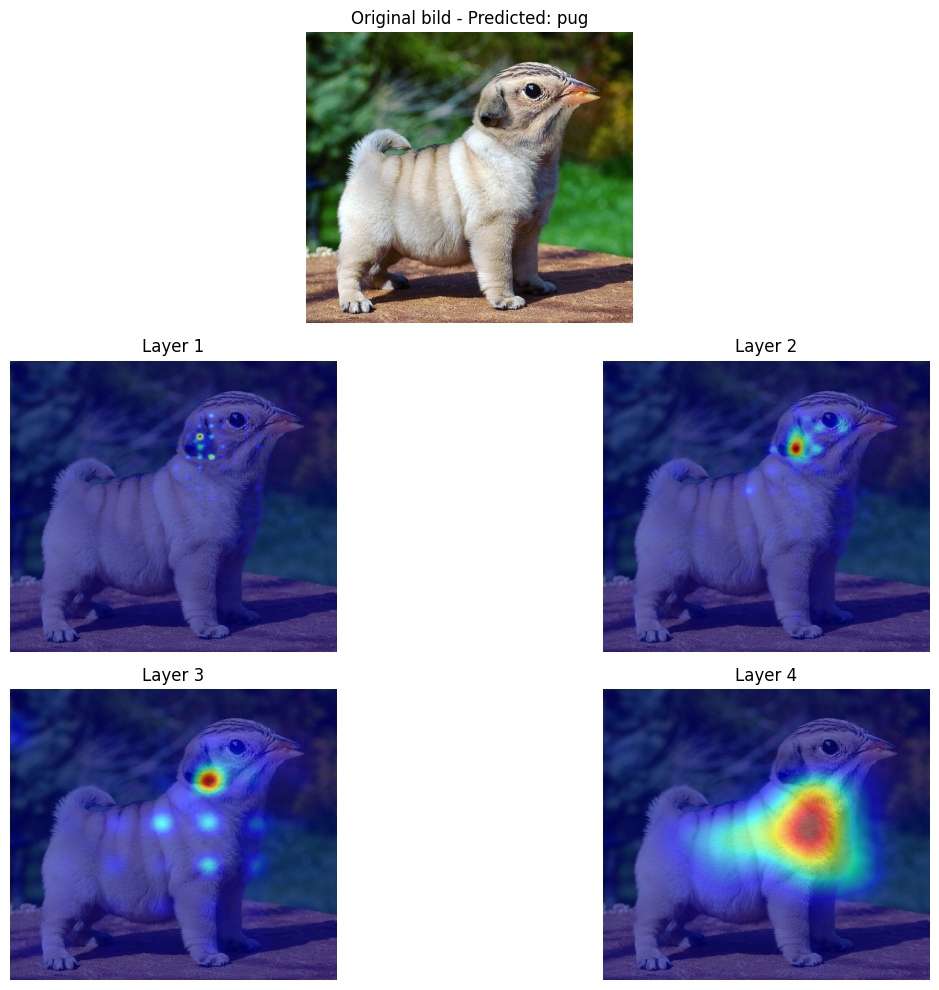

predictions:
1. pug                      0.096
2. chow                     0.045
3. Norwegian elkhound       0.024
4. Chihuahua                0.015
5. Brabancon griffon        0.013
6. jay                      0.012
7. basenji                  0.009
8. robin                    0.009
9. French bulldog           0.008
10. brambling                0.006


In [4]:

overlay_cam(*process_image('bog.jpg'))

Modellen plockar upp både fågeln och hunden men inte med särskilt stor säkerhet. Vi kan se att lager 1-3 fokuserar mer på små detaljer medans lager 4 reagerar starkt på en stor yta av päls. Här verkar det som att helheten spelar mest roll i avgörande av klass, och lager 4 står för detta beslut mest.


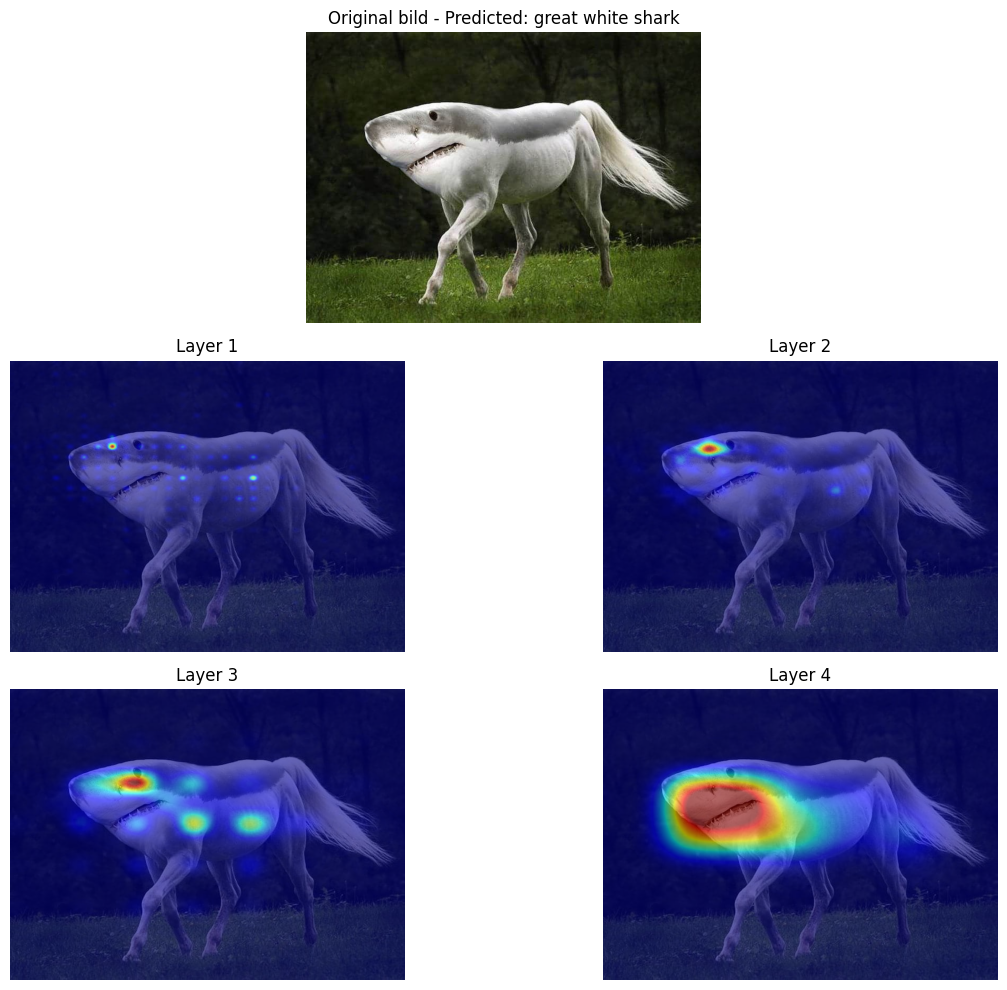

predictions:
1. great white shark        0.034
2. gazelle                  0.021
3. sorrel                   0.015
4. hartebeest               0.015
5. Saluki                   0.012
6. impala                   0.006
7. Ibizan hound             0.006
8. zebra                    0.006
9. tiger shark              0.006
10. English setter           0.005


In [5]:
overlay_cam(*process_image('shorse.jpg'))


Modellen Predictar haj med ganska låg konfidens, att modellen är osäker är dock förväntat pga hybrid-djuren. Vad som är anmärkningsvärt här är att trots att hästdjuren är med i högsta predictions så ser vi inte någon särskilt markant aktivering i något lager, förutom till viss del i lager 3. I lager 4 kan vi ana att fokuset ligger på det mest definierar djuret, i detta fall hajkäken, medans i förra bilden pälsen på hunden.


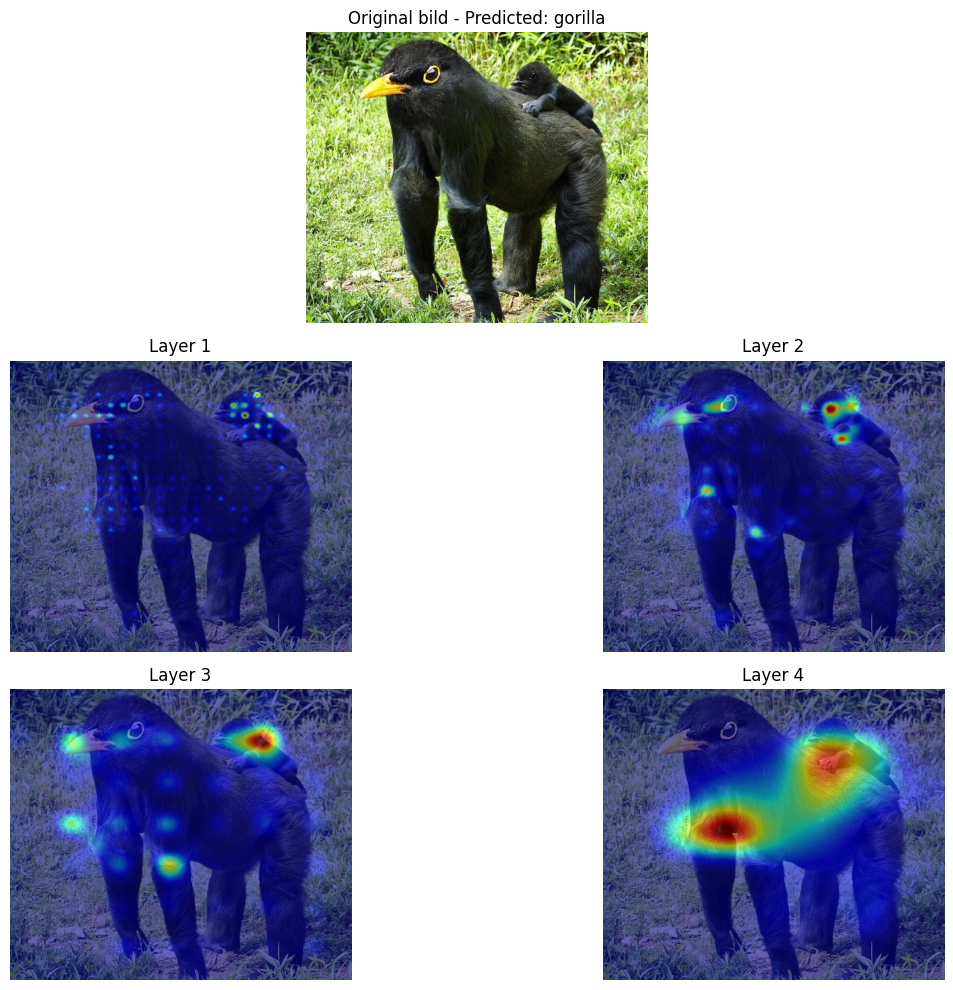

predictions:
1. gorilla                  0.236
2. chimpanzee               0.018
3. robin                    0.014
4. magpie                   0.010
5. siamang                  0.009
6. orangutan                0.004
7. macaque                  0.004
8. guenon                   0.003
9. patas                    0.003
10. oystercatcher            0.003


In [6]:
overlay_cam(*process_image('birdrilla.jpg'))


Vi kan återigen se att lager 1-3 reagerar på spridda detaljer, medans i lager 4 är aktiveringen koncentrerad på textur. Det verkar som att lager 4 väger tyngre än de lokala detaljer 1-3 plockar upp eftersom prediction för apdjur ligger högre än vad fågeldjur gör.


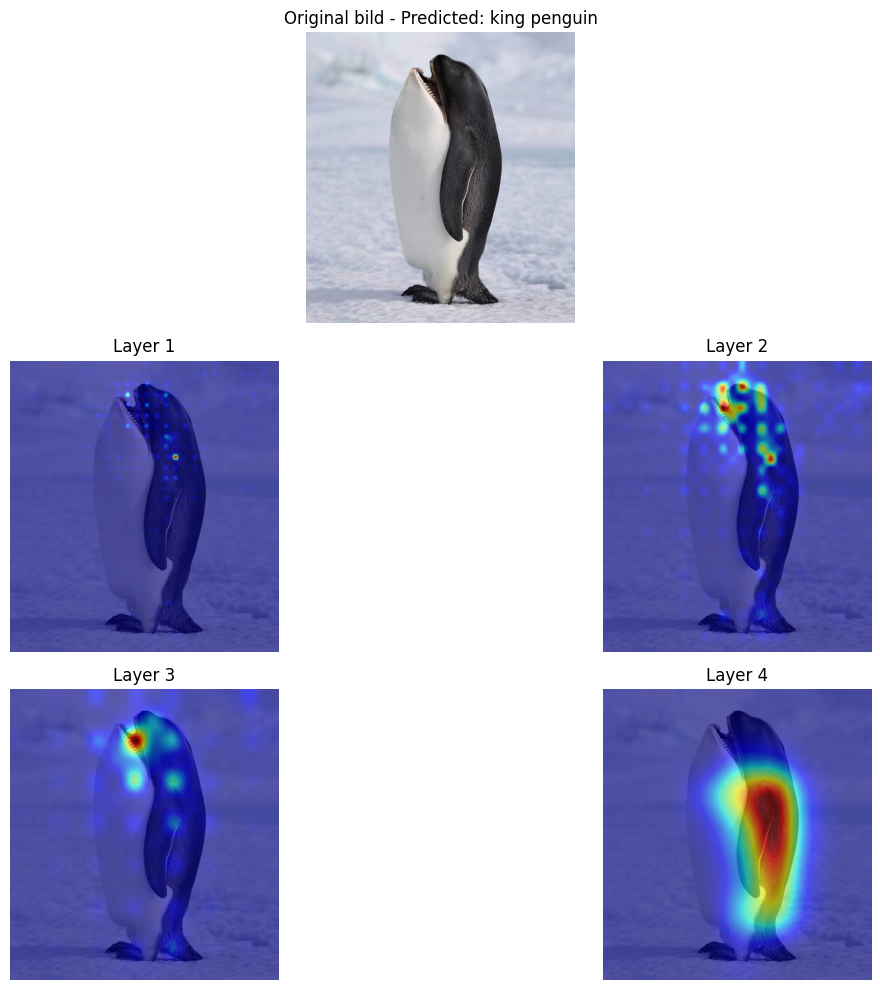

predictions:
1. king penguin             0.596
2. killer whale             0.012
3. sea lion                 0.003
4. ice bear                 0.002
5. albatross                0.001
6. white wolf               0.001
7. Arctic fox               0.001
8. grey whale               0.001
9. magpie                   0.001
10. brown bear               0.001


In [7]:
overlay_cam(*process_image('pengwhale.jpg'))


Till skillnad från tidigare bilder så har denna hybrid kropp och huvud som faktiskt "passar" relativt bra.
Och utefter vilken prediction modellen hade så kan vi se att modellen verkar värdera om helheten i bilden stämmer överens med klassen.
Lager 4 fokuserar återigen på det mest klassdefinierade draget i bilden, medans 1-3 verkar aktivera på små detaljer.


Sammanfattningsvis är CNNs väldigt bra på att hitta och fokusera på klassdefinierande features, och det är verkar som att nätverket behöver vara överens på flera lager för att göra en prediction med säkerhet. Min tolkning av resultaten är att lager 1-3 identifierar detaljer medans lager 4 reagerar starkt på en större klassdefinierande yta.